Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

In [1]:
#Подключим необходимые библиотеки
import re
import os
import sys
import csv
import nltk 
nltk.download('stopwords')
nltk.download('wordnet')
import string
import warnings
%matplotlib inline
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 100)
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from plot_metric.functions import BinaryClassification
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
class DataScience:

    def path_to_files(self, path, link):
        Path('datasets').mkdir(parents=True, exist_ok=True)
        def get_file(file_name, url):
            if not os.path.exists(file_name):
                print(file_name, 'файл не найден, будет загружен из сети')
                _ = urllib.request.urlretrieve(url, file_name)
        urls = {
            'dataset': (path, link)
        }
        [get_file(*urls[k]) for k in urls]
        data = pd.read_csv(urls['dataset'][0])
        return data

    

    def highlight_max(self, data, color='#00FF00'):
        '''
        highlight the maximum in a Series or DataFrame
        '''
        attr = 'background-color: {}'.format(color)
        # remove % and cast to float
        data = data.replace('%', '', regex=True).astype(float)
        data[data == 1] = None
        if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
            is_max = (data == data.abs().max()) & (data != 1)
            return [attr if v else '' for v in is_max]
        else:  # from .apply(axis=None)
            is_max = (data == data.abs().max()) & (data != 1)
            return pd.DataFrame(np.where(is_max, attr, ''),
                                index=data.index, columns=data.columns)

     
    def fit(self,train_features, train_actuals):
        for name in models.keys():
            est = models[name]
            est_params = params[name]
            gscv = GridSearchCV(estimator=est, param_grid=est_params, cv=5, n_jobs=-1,verbose=0)
            gscv.fit(train_features, train_actuals)     
            predictions = gscv.predict(tfidf_test)
            result_list.append({
            'model': name,
            'feature': feature,
            'f1_score': f1_score(y_test, predictions),
            'best_params': gscv.best_estimator_
            })

In [ ]:
ds = DataScience()

In [42]:
#Откроем и изучим наш датасет

data_path = "toxic_comments.csv"
data_raw = pd.read_csv(data_path)
print("Number of rows in data =",data_raw.shape[0])
print("Number of columns in data =",data_raw.shape[1])
print('Number of duplicates:', data_raw.duplicated().sum())
print('Number of NA values:', data_raw.isna().sum())
print("\n")
print("**Sample data:**")
data_raw.head()

Number of rows in data = 159571
Number of columns in data = 2
Number of duplicates: 0
Number of NA values: text     0
toxic    0
dtype: int64


**Sample data:**


,text,toxic
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


<AxesSubplot:xlabel='toxic', ylabel='count'>

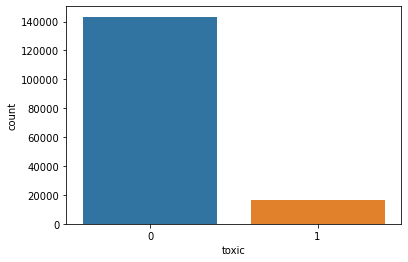

In [43]:
#Посмотрим на соотношение целевого признака. 
sns.countplot(x = 'toxic', data = data_raw)

### Исследовательский анализ данных
#### Визуализация Wordcloud

(-0.5, 399.5, 199.5, -0.5)

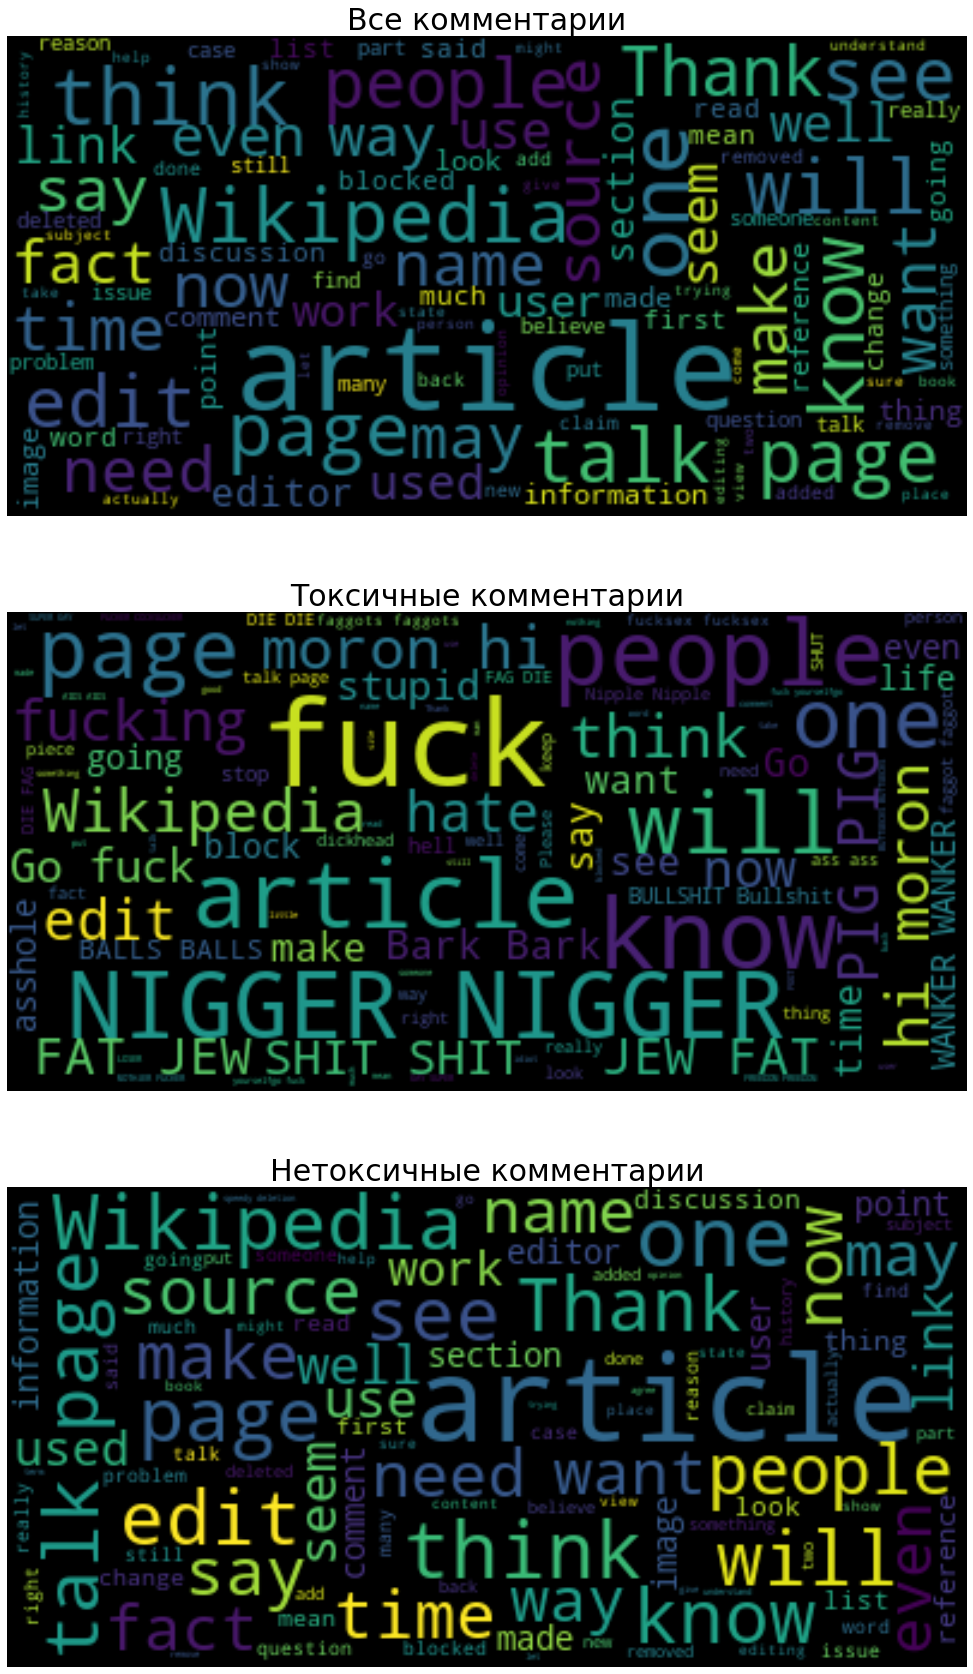

In [29]:
#Выведем облако комментариев: всех, токсичных и не токсичных комментариев

df_toxic = data_raw[data_raw['toxic']==1]
df_nottoxic = data_raw[data_raw['toxic']==0]

All = " ".join(review for review in data_raw.text)
toxic = " ".join(review for review in df_toxic.text)
nottoxic = " ".join(review for review in df_nottoxic.text)

fig, ax = plt.subplots(3, 1, figsize  = (30,30))
wordcloud_all = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(All)
wordcloud_toxic = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(toxic)
wordcloud_nottoxic = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(nottoxic)


ax[0].imshow(wordcloud_all, interpolation='bilinear')
ax[0].set_title('Все комментарии', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_toxic, interpolation='bilinear')
ax[1].set_title('Токсичные комментарии',fontsize=30)
ax[1].axis('off')
ax[2].imshow(wordcloud_nottoxic, interpolation='bilinear')
ax[2].set_title('Нетоксичные комментарии',fontsize=30)
ax[2].axis('off')

- Несколько высокочастотных токенов, таких как «wikipedia», «article», «think», часто используются в обоих категориальных классах (токсичных/не токсичных)

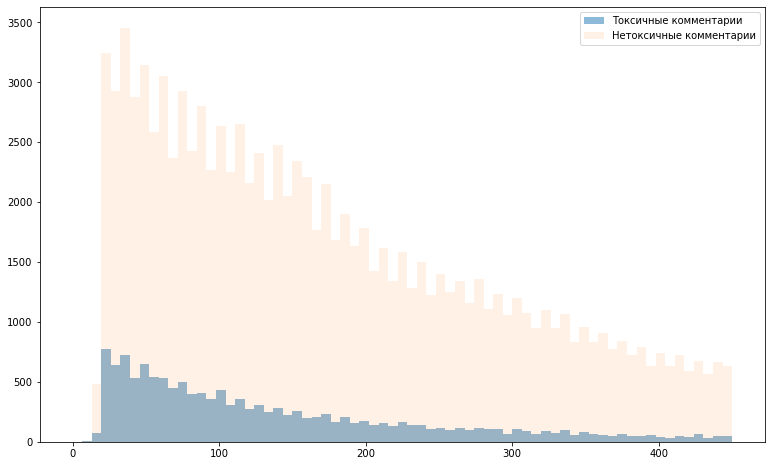

In [30]:
#Посмотрим у каких комментариев длиннее текст
TOXIC_1 = data_raw[data_raw['toxic'] == 1]['text'].apply(lambda x: len(x) - len(' '))
TOXIC_0 = data_raw[data_raw['toxic'] == 0]['text'].apply(lambda x: len(x) - len(' '))
bins_ = np.linspace(0, 450, 70)
plt.figure(figsize=(13,8))
plt.hist(TOXIC_1, bins= bins_, alpha = 0.5, label = 'Токсичные комментарии')
plt.hist(TOXIC_0, bins= bins_, alpha = 0.1, label = 'Нетоксичные комментарии')
plt.legend()

Определенно у нетоксичных комментариев длина комментария больше чем у токсичного комментария

## Предобработка данных

###### Для очистки большей части текстовых данных выполним следующие действия.

- Удалим знаки препинания
- Токенизация - преобразуем предложения в список слов
- Удалим stop слова
- Ламметизация / стемминг - преобразуем любой формы слова в его корневое слово.

In [9]:
#Удалим пунктуацию, но прежде скопируем датасет в переменную "data"

data = data_raw
if not sys.warnoptions:
    warnings.simplefilter("ignore")


def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

data['punct'] = data['text'].apply(lambda x: remove_punct(x))
data.head(3)

,text,toxic,punct
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted They were...
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0,Daww He matches this background colour Im seemingly stuck with Thanks talk January UTC
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0,Hey man Im really not trying to edit war Its just that this guy is constantly removing relevant ...


In [10]:
#Проведем токенизацию

def tokenization(text):
    text = re.split('\W+', text)
    return text

data['tokenized'] = data['punct'].apply(lambda x: tokenization(x.lower()))
data.head(3)

,text,toxic,punct,tokenized
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted They were...,"[explanation, why, the, edits, made, under, my, username, hardcore, metallica, fan, were, revert..."
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0,Daww He matches this background colour Im seemingly stuck with Thanks talk January UTC,"[daww, he, matches, this, background, colour, im, seemingly, stuck, with, thanks, talk, january,..."
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0,Hey man Im really not trying to edit war Its just that this guy is constantly removing relevant ...,"[hey, man, im, really, not, trying, to, edit, war, its, just, that, this, guy, is, constantly, r..."


In [11]:
#Удалим стоп-слова

stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
data['nonstop'] = data['tokenized'].apply(lambda x: remove_stopwords(x))
data.head(3)

,text,toxic,punct,tokenized,nonstop
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted They were...,"[explanation, why, the, edits, made, under, my, username, hardcore, metallica, fan, were, revert...","[explanation, edits, made, username, hardcore, metallica, fan, reverted, werent, vandalisms, clo..."
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0,Daww He matches this background colour Im seemingly stuck with Thanks talk January UTC,"[daww, he, matches, this, background, colour, im, seemingly, stuck, with, thanks, talk, january,...","[daww, matches, background, colour, im, seemingly, stuck, thanks, talk, january, utc]"
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0,Hey man Im really not trying to edit war Its just that this guy is constantly removing relevant ...,"[hey, man, im, really, not, trying, to, edit, war, its, just, that, this, guy, is, constantly, r...","[hey, man, im, really, trying, edit, war, guy, constantly, removing, relevant, information, talk..."


In [12]:
#Стемминг
sys.setrecursionlimit(160000)
ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

data['stemmed'] = data['nonstop'].apply(lambda x: stemming(x))
data.head(3)

,text,toxic,punct,tokenized,nonstop,stemmed
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted They were...,"[explanation, why, the, edits, made, under, my, username, hardcore, metallica, fan, were, revert...","[explanation, edits, made, username, hardcore, metallica, fan, reverted, werent, vandalisms, clo...","[explan, edit, made, usernam, hardcor, metallica, fan, revert, werent, vandal, closur, ga, vote,..."
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0,Daww He matches this background colour Im seemingly stuck with Thanks talk January UTC,"[daww, he, matches, this, background, colour, im, seemingly, stuck, with, thanks, talk, january,...","[daww, matches, background, colour, im, seemingly, stuck, thanks, talk, january, utc]","[daww, match, background, colour, im, seemingli, stuck, thank, talk, januari, utc]"
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0,Hey man Im really not trying to edit war Its just that this guy is constantly removing relevant ...,"[hey, man, im, really, not, trying, to, edit, war, its, just, that, this, guy, is, constantly, r...","[hey, man, im, really, trying, edit, war, guy, constantly, removing, relevant, information, talk...","[hey, man, im, realli, tri, edit, war, guy, constantli, remov, relev, inform, talk, edit, instea..."


In [13]:
#Лемматизация

wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

data['lemmatized'] = data['nonstop'].apply(lambda x: lemmatizer(x))
data.head(3)

,text,toxic,punct,tokenized,nonstop,stemmed,lemmatized
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted They were...,"[explanation, why, the, edits, made, under, my, username, hardcore, metallica, fan, were, revert...","[explanation, edits, made, username, hardcore, metallica, fan, reverted, werent, vandalisms, clo...","[explan, edit, made, usernam, hardcor, metallica, fan, revert, werent, vandal, closur, ga, vote,...","[explanation, edits, made, username, hardcore, metallica, fan, reverted, werent, vandalism, clos..."
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0,Daww He matches this background colour Im seemingly stuck with Thanks talk January UTC,"[daww, he, matches, this, background, colour, im, seemingly, stuck, with, thanks, talk, january,...","[daww, matches, background, colour, im, seemingly, stuck, thanks, talk, january, utc]","[daww, match, background, colour, im, seemingli, stuck, thank, talk, januari, utc]","[daww, match, background, colour, im, seemingly, stuck, thanks, talk, january, utc]"
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0,Hey man Im really not trying to edit war Its just that this guy is constantly removing relevant ...,"[hey, man, im, really, not, trying, to, edit, war, its, just, that, this, guy, is, constantly, r...","[hey, man, im, really, trying, edit, war, guy, constantly, removing, relevant, information, talk...","[hey, man, im, realli, tri, edit, war, guy, constantli, remov, relev, inform, talk, edit, instea...","[hey, man, im, really, trying, edit, war, guy, constantly, removing, relevant, information, talk..."


# 2. Обучение

#### План работы:
- Разделим датасет на обучающую и тестовую выборку с соотношение 70:30
- С помощью GridSearchCV будем подбирать наилучшие параметры к каждой фиче нашего датасета. Посмотрим какая из них даст наилучший результат
- Сохраним все результаты в таблицу для дальнейшего изучения

In [14]:
#разделим выборки на обучающую и тестовую 
train, test = train_test_split(data, test_size=.30, random_state=123)

In [15]:
#Вызовем TFIDF
count_tf_idf = TfidfVectorizer()

In [21]:
models = {
    'LogisticRegression': LogisticRegression(),
    'LGBMClassifier': lgb.LGBMClassifier()
}


params = {
    'LogisticRegression':{
          'class_weight':['balanced', None],
          'C':[1,10,100]
    },        

    'LGBMClassifier': {
        'boosting_type':['gbdt'],
        'objective':['binary'],
        'learning_rate':[0.02,0.05],
        'num_iterations':[500],
        'num_leaves':[50,75],
        'feature_fraction':[0.64,0.8],
        'bagging_fraction':[0.8,0.9],
        'bagging_freq':[1,2]
        }
}

In [23]:
%%time
result_list = []
features = ['lemmatized','text','punct','tokenized','nonstop','stemmed']

for feature in features:
    X_train = train[feature]
    y_train = train['toxic']
    X_test = test[feature]
    y_test = test['toxic']

    train_corpus = X_train.astype('U')
    tfidf = count_tf_idf.fit_transform(train_corpus) 
    corpus_test = X_test.astype('U')
    tfidf_test = count_tf_idf.transform(corpus_test)

    ds.fit(tfidf, y_train)

[LightGBM] [Warning] feature_fraction is set=0.64, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will

In [34]:
results = pd.DataFrame(result_list, columns=['model','feature','f1_score','best_params'])

# 3. Выводы

In [41]:
results.style.highlight_max(color = 'lightgreen', axis = 0)

,model,feature,f1_score,best_params
0,LogisticRegression,lemmatized,0.778339,LogisticRegression(C=10)
1,LGBMClassifier,lemmatized,0.786275,"LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, feature_fraction=0.64, learning_rate=0.05, num_iterations=500, num_leaves=50, objective='binary')"
2,LogisticRegression,text,0.785351,LogisticRegression(C=10)
3,LGBMClassifier,text,0.788266,"LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, feature_fraction=0.8, learning_rate=0.05, num_iterations=500, num_leaves=75, objective='binary')"
4,LogisticRegression,punct,0.785455,LogisticRegression(C=10)
5,LGBMClassifier,punct,0.786570,"LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, feature_fraction=0.8, learning_rate=0.05, num_iterations=500, num_leaves=75, objective='binary')"
6,LogisticRegression,tokenized,0.785455,LogisticRegression(C=10)
7,LGBMClassifier,tokenized,0.786570,"LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, feature_fraction=0.8, learning_rate=0.05, num_iterations=500, num_leaves=75, objective='binary')"
8,LogisticRegression,nonstop,0.776027,LogisticRegression(C=10)
9,LGBMClassifier,nonstop,0.783069,"LGBMClassifier(bagging_fraction=0.9, bagging_freq=2, feature_fraction=0.8, learning_rate=0.05, num_iterations=500, num_leaves=50, objective='binary')"


- Как можно видеть из результатов подбора параметров с разными моделями, наилучший результат набрала модель LGBMClassifier с F1_score - 0.788 на тестовой выборке. 
- Удивительно, что именно сырой текст без какой-либо обрабобтки дает лучшие результаты. 

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны